This script serves as a sanity check on the representation level.
The different data representations are used to classify call types as a proof of sufficient information.

DFA (PAFs), simple MLPs (LFCCs) and CNNs (spectrograms) are used to classify the different call types.

In [2]:
import pandas as pd
import numpy as np
import json
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision.transforms import Compose, Lambda
from sklearn.model_selection import StratifiedGroupKFold, permutation_test_score, GroupShuffleSplit
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)

RandomState(MT19937) at 0x12AFC8040

### Create internal functions

In [4]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):  
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        cm = confusion_matrix(true_labels, predicted_labels, normalize=normalize)
        plt.figure(figsize=(8, 6))
        if normalize:
            sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        else:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

    plt.show()  

In [4]:
# def _compute_roc_curve(val_targets, val_probs, num_classes):
#     val_targets = np.array(val_targets)
#     val_probs = np.array(val_probs)

#     all_labels_binarized = label_binarize(val_targets, classes=np.arange(num_classes))
#     fpr = {}
#     tpr = {}
#     roc_auc = {}

#     # For each class, compute the ROC curve and AUC
#     for i in range(num_classes):
#         fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], val_probs[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Micro-average ROC curve
#     fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), val_probs.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#     # Macro-average ROC curve
#     all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
#     mean_tpr = np.zeros_like(all_fpr)
#     for i in range(num_classes):
#         mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
#     mean_tpr /= num_classes

#     fpr["macro"] = all_fpr
#     tpr["macro"] = mean_tpr
#     roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#     print(fpr["micro"].shape, tpr["micro"].shape, fpr["macro"].shape, tpr["macro"].shape, roc_auc["micro"], roc_auc["macro"])

#     return fpr, tpr, roc_auc

In [5]:
# def plot_roc_curve(true_labels, all_probs, num_classes, class_names):
#     fpr, tpr, roc_auc = _compute_roc_curve(true_labels, all_probs, num_classes)

#     # Plot ROC curve for each class
#     plt.figure(figsize=(10, 8))
#     for i in range(num_classes):
#         plt.plot(fpr[i], tpr[i], label = f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

#     # Plot micro-average and macro-average ROC curves
#     plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color="blue")
#     plt.plot(fpr["macro"], tpr["macro"], label=f"Macro-average (AUC = {roc_auc['macro']:.2f})", linestyle='-.', color="navy")
    
#     # Plot the diagonal (random guess)
#     plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    
#     # Configure the plot
#     plt.title("ROC Curve")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend(loc="lower right")
#     plt.grid()
#     plt.show()

In [5]:
def train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion):
    # Train model
    model.train()
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_dl):.4f}")

In [7]:
# def plot_roc_curve_with_ci(all_fpr_micro, all_tpr_micro, all_fpr_macro, all_tpr_macro, alpha=0.95):
#     print(len(all_fpr_micro[0], all_fpr_micro[1]))
#     all_fpr_micro = np.asarray(all_fpr_micro)
#     all_tpr_micro = np.asarray(all_tpr_micro)
#     all_fpr_macro = np.asarray(all_fpr_macro)
#     all_tpr_macro = np.asarray(all_tpr_macro)

#     # Calculate mean and confidence intervals for micro-average
#     mean_fpr_micro = np.mean(all_fpr_micro, axis=0)
#     mean_tpr_micro = np.mean(all_tpr_micro, axis=0)
#     tpr_micro_lower = np.percentile(all_tpr_micro, (1 - alpha) / 2 * 100, axis=0)
#     tpr_micro_upper = np.percentile(all_tpr_micro, (1 + alpha) / 2 * 100, axis=0)

#     # Calculate mean and confidence intervals for macro-average
#     mean_fpr_macro = np.mean(all_fpr_macro, axis=0)
#     mean_tpr_macro = np.mean(all_tpr_macro, axis=0)
#     tpr_macro_lower = np.percentile(all_tpr_macro, (1 - alpha) / 2 * 100, axis=0)
#     tpr_macro_upper = np.percentile(all_tpr_macro, (1 + alpha) / 2 * 100, axis=0)

#     # Plot ROC curve with confidence intervals
#     plt.figure(figsize=(10, 8))

#     # micro-average
#     plt.plot(mean_fpr_micro, mean_tpr_micro, label=f"Micro-average (AUC = {auc(mean_fpr_micro, mean_tpr_micro):.2f})", linestyle='--', color="blue")
#     plt.fill_between(mean_fpr_micro, tpr_micro_lower, tpr_micro_upper, color='blue', alpha=0.2)

#     # macro-average
#     plt.plot(mean_fpr_macro, mean_tpr_macro, label=f"Macro-average (AUC = {auc(mean_fpr_macro, mean_tpr_macro):.2f})", linestyle='-.', color="navy")
#     plt.fill_between(mean_fpr_macro, tpr_macro_lower, tpr_macro_upper, color='navy', alpha=0.2)

#     plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

#     plt.title("ROC Curve")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend(loc="lower right")
#     plt.grid()
#     plt.show()

In [6]:
def test_model(model, test_dl, device):
    true_labels = []
    predicted_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            
            _, predicted = torch.max(outputs, 1)
            
            true_labels.append(labels.cpu().numpy())
            predicted_labels.append(predicted.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    return true_labels, predicted_labels, all_probs

In [7]:
def create_evaluation_plots(true_labels, predicted_labels, label_encoder, all_probs=None, num_classes=None):
    y_test_labels = label_encoder.inverse_transform(true_labels)
    y_pred_labels = label_encoder.inverse_transform(predicted_labels)
    print(classification_report(y_test_labels, y_pred_labels))
    plot_confusion_matrix(y_test_labels, y_pred_labels, label_encoder.classes_)
    if all_probs is None:
        return
    assert not num_classes is None
    #plot_roc_curve(true_labels, all_probs, num_classes, label_encoder.classes_)
    
def evaluate_model(model, test_dl, device, label_encoder, num_classes):
    true_labels, predicted_labels, all_probs = test_model(model, test_dl, device)
    create_evaluation_plots(true_labels, predicted_labels, label_encoder, all_probs, num_classes)

In [8]:
def verify_splits(dataset, sgkf):
    """
    Verifies that StratifiedGroupKFold splits are not holding any of the same track IDs across sets.

    Args:
        dataset (LFCCDataset): The dataset object.
        sgkf (StratifiedGroupKFold): The StratifiedGroupKFold object.
    """
    df = dataset.df
    groups = dataset.groups
    y = df["encoded_call_type"]

    for fold, (train_idx, val_idx) in enumerate(sgkf.split(df, y, groups=groups)):
        train_groups = set(groups.iloc[train_idx])
        val_groups = set(groups.iloc[val_idx])

        assert train_groups.isdisjoint(val_groups), f"Overlap found in groups for Fold {fold + 1}"
    return True

In [9]:
def _plot_roc_auc_curves_cv(mean_fpr, mean_micro_tpr, micro_tprs_lower, micro_auc_scores, micro_tprs_upper, mean_macro_tpr, macro_auc_scores, macro_tprs_lower, macro_tprs_upper, n_classes, tprs_per_class, label_encoder, roc_auc):
    fig, ax = plt.subplots(figsize=(9, 9))
    # Plot micro-average ROC curve with CI
    ax.plot(
        mean_fpr,
        mean_micro_tpr,
        label=f"Micro-average ROC curve ± 1 std. dev.(AUC = {np.mean(micro_auc_scores):.2f})",
        color="deeppink",
        linestyle="--",
        linewidth=1.5,
    )
    ax.fill_between(
        mean_fpr,
        micro_tprs_lower,
        micro_tprs_upper,
        color="pink",
        alpha=0.2,
    )

    # Plot macro-average ROC curve with CI
    ax.plot(
        mean_fpr,
        mean_macro_tpr,
        label=f"Macro-average ROC curve ± 1 std. dev.(AUC = {np.mean(macro_auc_scores):.2f})",#np.mean([auc(fpr[class_idx], tpr[class_idx]) for class_idx in range(n_classes)])
        color="navy",
        linestyle="--",
        linewidth=1.5,
    )
    ax.fill_between(
        mean_fpr,
        macro_tprs_lower,
        macro_tprs_upper,
        color="blue",
        alpha=0.2,
    )

    # Plot average curve per class
    for class_idx in range(n_classes):
        mean_tpr = np.mean(tprs_per_class[class_idx], axis=0)
        std_tpr = np.std(tprs_per_class[class_idx], axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

        # Plot mean ROC curve with AUC
        ax.plot(mean_fpr, mean_tpr, label=f"Class {label_encoder.inverse_transform([class_idx])[0]} ± 1 std. dev. (AUC = {roc_auc[class_idx]:.2f})")
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)

    # Plot random
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", alpha=0.5)

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC One-vs-Rest multiclass",
    )
    
    ax.legend(loc="lower right")
    plt.show()  

In [10]:
# https://scikit-learn.org/1.5/auto_examples/model_selection/plot_roc_crossval.html accessed January 14th, 19:04pm
# https://scikit-learn.org/1.5/auto_examples/model_selection/plot_roc.html accessed January 14th, 20:17pm
def cross_validate(dataset, model_class, device, label_encoder, batch_size, learning_rate, n_splits=5, n_epochs=10, n_classes=6, **model_kwargs):
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED) # enables splitting by tracks
    
    assert verify_splits(dataset, sgkf)

    fold_results = []

    tprs_per_class = {class_idx: [] for class_idx in range(n_classes)}
    mean_fpr = np.linspace(0, 1, 1000)
    micro_tprs = []
    macro_tprs = []
    micro_auc_scores = []
    macro_auc_scores = []
    fpr, tpr, roc_auc = dict(), dict(), dict()

    fold_results = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'micro_auc': [],
            'macro_auc': [],
        }

    for fold, (train_idx, val_idx) in enumerate(sgkf.split(dataset.df, dataset.df["encoded_call_type"], groups=dataset.groups)):
        torch.cuda.empty_cache()
        print(f"\n--- Fold {fold + 1} ---")
        model = model_class(num_classes=n_classes, **model_kwargs).to(device)
        
        # Create data loaders for current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Instantiate model, loss, optimizer
        loss_criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)

        val_targets, val_predictions, val_probs = test_model(model, val_dl, device)
        label_binarizer = LabelBinarizer().fit([y for _, y in dataset])
        y_onehot_test = label_binarizer.transform(val_targets)
        val_probs = np.array(val_probs)

        # Compute validation accuracy
        fold_accuracy = accuracy_score(val_targets, val_predictions)
        print(f"\nValidation Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")
        #-------------End of training---------    

        tprs_for_macro = []

        # Per class ROC curve
        for class_idx in range(n_classes):
            fpr[class_idx], tpr[class_idx], _ = roc_curve(y_onehot_test[:, class_idx], val_probs[:, class_idx])
            roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])
        
            # Interpolate TPR values on the fixed FPR grid
            interp_tpr = np.interp(mean_fpr, fpr[class_idx], tpr[class_idx])
            interp_tpr[0] = 0.0  # Ensure TPR starts at 0
            tprs_per_class[class_idx].append(interp_tpr)
            tprs_for_macro.append(interp_tpr)

            
        # Compute micro-average ROC curve and ROC area
        # store the fpr, tpr, and roc_auc for all averaging strategies
        fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), val_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        micro_auc_scores.append(roc_auc["micro"])

        # Interpolate TPR values on the fixed FPR grid
        interp_tpr = np.interp(mean_fpr, fpr["micro"], tpr["micro"])
        interp_tpr[0] = 0.0  # Ensure TPR starts at 0
        micro_tprs.append(interp_tpr)
        
        print(f"  Micro-averaged One-vs-Rest ROC AUC score: {roc_auc['micro']:.2f}")

        # Compute the macro-average TPR for this fold
        macro_tpr = np.mean(tprs_for_macro, axis=0)
        macro_tpr[-1] = 1.0  # Ensure TPR ends at 1
        macro_tprs.append(macro_tpr)
        macro_auc = auc(mean_fpr, macro_tpr)

        print(f"  Macro-averaged One-vs-Rest ROC AUC score: {macro_auc:.2f}")
        macro_auc_scores.append(macro_auc)

        #-----------Additional metrics-----------
        fold_precision = precision_score(val_targets, val_predictions, average='weighted', zero_division=0)
        fold_recall = recall_score(val_targets, val_predictions, average='weighted', zero_division=0)
        fold_f1 = f1_score(val_targets, val_predictions, average='weighted', zero_division=0)

        print(f"  Accuracy: {fold_accuracy:.4f}")
        print(f"  Precision (weighted): {fold_precision:.4f}")
        print(f"  Recall (weighted): {fold_recall:.4f}")
        print(f"  F1-score (weighted): {fold_f1:.4f}")

        fold_results['accuracy'].append(fold_accuracy)
        fold_results['precision'].append(fold_precision)
        fold_results['recall'].append(fold_recall)
        fold_results['f1'].append(fold_f1)
        fold_results['micro_auc'].append(roc_auc['micro'])
        fold_results['macro_auc'].append(macro_auc)

    #-------------End of fold--------------

    metrics_summary = {
        metric: {
            'mean': np.mean(values),
            'std': np.std(values)
        } for metric, values in fold_results.items()
    }

    print("\nCross-Validation Results:")
    for metric, stats in metrics_summary.items():
        print(f"  {metric.capitalize()} - Mean: {stats['mean']:.4f}, Std Dev: {stats['std']:.4f}")

    # Compute mean and std for micro-average TPRs
    mean_micro_tpr = np.mean(micro_tprs, axis=0)
    std_micro_tpr = np.std(micro_tprs, axis=0)
    micro_tprs_upper = np.minimum(mean_micro_tpr + std_micro_tpr, 1)
    micro_tprs_lower = np.maximum(mean_micro_tpr - std_micro_tpr, 0)

    # Compute mean and std for macro-average TPRs
    mean_macro_tpr = np.mean(macro_tprs, axis=0)
    std_macro_tpr = np.std(macro_tprs, axis=0)
    macro_tprs_upper = np.minimum(mean_macro_tpr + std_macro_tpr, 1)
    macro_tprs_lower = np.maximum(mean_macro_tpr - std_macro_tpr, 0)

    #--------------Plots----------------
    roc_auc_data = {
        'mean_fpr': mean_fpr,
        'mean_micro_tpr': mean_micro_tpr,
        'micro_tprs_lower': micro_tprs_lower,
        'micro_auc_scores': micro_auc_scores,
        'micro_tprs_upper': micro_tprs_upper,
        'mean_macro_tpr': mean_macro_tpr,
        'macro_auc_scores': macro_auc_scores,
        'macro_tprs_lower': macro_tprs_lower,
        'macro_tprs_upper': macro_tprs_upper,
        'n_classes': n_classes,
        'tprs_per_class': tprs_per_class,
        'label_encoder': label_encoder,
        'roc_auc': roc_auc
    }
    _plot_roc_auc_curves_cv(**roc_auc_data)

    return metrics_summary

In [11]:
def bootstrap_model(dataset, model_class, device, batch_size, learning_rate, num_bootstrap_samples=10, n_epochs=10, **model_kwargs):
    bootstrap_results = []

    for i in range(num_bootstrap_samples):
        print(f"\n--- Bootstrap Sample {i + 1} ---")
        
        # Generate bootstrap sample (with replacement)
        indices = resample(range(len(dataset)), replace=True, n_samples=len(dataset), random_state=i)
        oob_indices = list(set(range(len(dataset))) - set(indices))  # Out-of-Bag (OOB) indices

        train_subset = Subset(dataset, indices)
        oob_subset = Subset(dataset, oob_indices)
        train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        oob_dl = DataLoader(oob_subset, batch_size=batch_size, shuffle=False)
        
        # Instantiate model, loss, and optimizer
        model = model_class(**model_kwargs).to(device)
        loss_criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)
        oob_targets, oob_predictions, _ = test_model(model, oob_dl, device)

        # Compute OOB accuracy
        if oob_targets: 
            oob_accuracy = accuracy_score(oob_targets, oob_predictions)
            print(f"OOB Accuracy for Bootstrap Sample {i + 1}: {oob_accuracy:.4f}")
            bootstrap_results.append(oob_accuracy)
        else:
            print("No OOB samples for this bootstrap iteration.")
            bootstrap_results.append(None)

    # Final bootstrap results
    print("\nBootstrap Results:")
    for i, acc in enumerate(bootstrap_results):
        print(f"Bootstrap Sample {i + 1}: {acc if acc is not None else 'N/A'}")
    valid_accuracies = [acc for acc in bootstrap_results if acc is not None]
    if valid_accuracies:
        print(f"Average OOB Accuracy: {sum(valid_accuracies) / len(valid_accuracies):.4f}")
    else:
        print("No valid OOB accuracy to average.")


### Load data

In [12]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))
calls_df['log_padded_lfccs'] = calls_df['log_padded_lfccs'].apply(lambda x: np.asarray(json.loads(x)))

In [13]:
representations_df = pd.read_csv("latent_representations_CVAE.csv")
representations_df["latent_representation"] = representations_df["latent_representation"].apply(lambda x: np.asarray(json.loads(x)))
calls_df = pd.merge(calls_df, representations_df, on="clip_ID")
calls_df = calls_df.drop(columns=["call_type_y"])
calls_df = calls_df.rename(columns={"call_type_x": "call_type"})

In [14]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df = calls_df[calls_df['call_type'] != 'unknown']
calls_df.info()

0
<class 'pandas.core.frame.DataFrame'>
Index: 7129 entries, 0 to 7282
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_ID                7129 non-null   object 
 1   clip_ID                 7129 non-null   object 
 2   goose_ID                7129 non-null   object 
 3   call_type               7129 non-null   object 
 4   waveform                7129 non-null   object 
 5   sr                      7129 non-null   int64  
 6   filepath                7129 non-null   object 
 7   lfccs                   7129 non-null   object 
 8   peak                    7129 non-null   float64
 9   duration                7129 non-null   float64
 10  log_padded_spectrogram  7129 non-null   object 
 11  log_padded_lfccs        7129 non-null   object 
 12  t_q1                    7129 non-null   float64
 13  t_median                7129 non-null   float64
 14  t_q3                    7129 non-null   flo

In [15]:
subsample_sizes = {
    'recruitment': 1700,
}

# Randomly subsample recruitment calls to get roughly the same count as the contact call set
def subsample_group(group):
    call_type = group.name  # Group name corresponds to call type
    if call_type in subsample_sizes:
        return group.sample(n=subsample_sizes[call_type], random_state=42)
    return group  # Return untouched if no subsampling is needed

# Group by type and apply subsampling
calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_8531/4029748789.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)


## DFA

#### Audio features

In [23]:
feature_titles_list = [
    "Duration [s]",
    "Temporal 1st Quartile [s]", 
    "Temporal Median [s]", 
    "Temporal 3rd Quartile [s]", 
    "Temporal Standard Deviation [s]", 
    "Temporal Skewness", 
    "Temporal Kurtosis", 
    "Temporal Entropy", 
    "Mean Frequency [kHz]",
    "Mean Peak Frequency [kHz]",
    "Spectral Sandard Deviation [kHz]",
    "Spectral Flatness", 
    "Frequency 1st Quartile [kHz]",
    "Frequency Median [kHz]", 
    "Frequency 3rd Quartile [kHz]", 
    "Mean Dominant Frequency [kHz]", 
    "Min Dominant Frequency [kHz]",
    "Max Dominant Frequency [kHz]", 
    "Dominant Frequency Range [kHz]", 
    "Dominant Frequency Modulation [kHz]", 
    "Spectral Entropy", 
    "Harmonics-to-Noise Ratio [dB]",
    "Spectrographic Entropy"
    ]

# List of column names of PAFs
features_list = [
    "duration",
    "t_q1", 
    "t_median", 
    "t_q3", 
    "std_t", 
    "skew_t", 
    "kurt_t", 
    "t_entropy", 
    "mean_f",
    "mean_peak_f", 
    "std_f",
    "flatness_s", 
    "f_q1",
    "f_median", 
    "f_q3", 
    "mean_dom", 
    "min_dom",
    "max_dom", 
    "range_dom", 
    "mod_dom", 
    "pse", 
    "hnr",
    "spectrographic_entropy"
    ]

log_feature = [
    True, 
    True, 
    True, 
    False, 
    False, 
    False,  
    False,  
    False, 
    True, 
    True, 
    False,
    False, 
    False, 
    True, 
    True, 
    True, 
    True, 
    True, 
    True,
    True, 
    True, 
    True, 
    True, 
    True
]

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_8531/295913291.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_8531/295913291.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


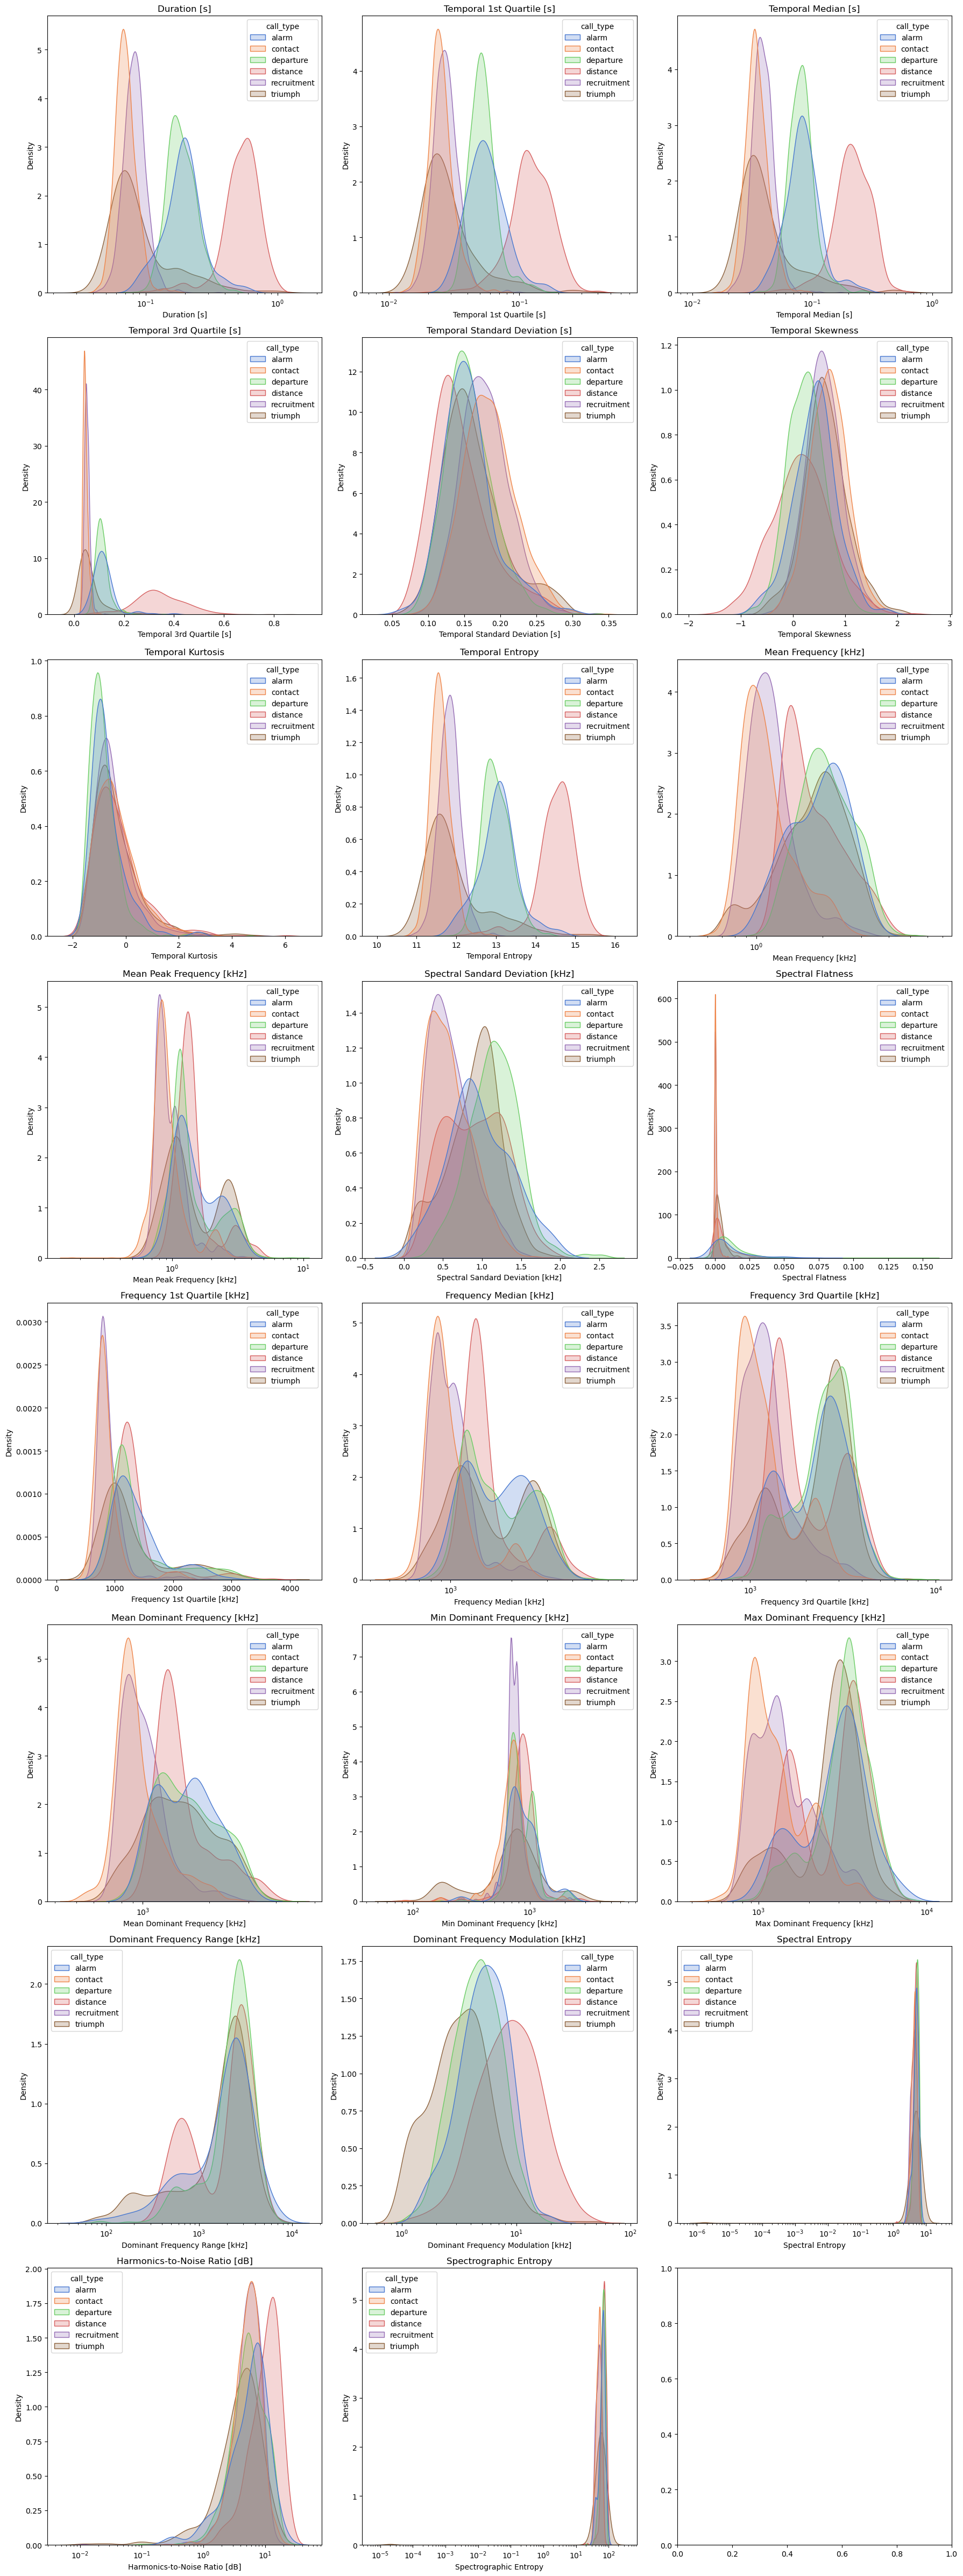

In [24]:
# TODO look into https://seaborn.pydata.org/examples/kde_ridgeplot.html
n_features = len(features_list)
n_columns = 3
n_rows = (n_features + n_columns - 1) // n_columns

fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(6*n_columns, 6*n_rows))
axes = axes.flatten()

for ax, feature, plot_title, log_scaled in zip(axes, features_list, feature_titles_list, log_feature):
    try:
        # Use KDE plots for ridge plot style
        sns.kdeplot(
            data=calls_df, 
            x=feature,
            hue="call_type", 
            fill=True, 
            common_norm=False,
            palette="muted", 
            linewidth=1,
            log_scale=log_scaled, 
            ax=ax
        )
        ax.set_xlabel(plot_title)
        ax.set_title(plot_title)
    except:
        continue

plt.tight_layout()
plt.show()


In [19]:
le = LabelEncoder()
y = le.fit_transform(calls_df["call_type"])
X = calls_df[features_list].values
X_scaled = StandardScaler().fit_transform(X)
track_ids = calls_df['track_ID'].values

In [20]:
indices = np.arange(len(calls_df))

train_idxs, test_idxs, X_train, X_test, y_train, y_test = train_test_split(
    indices, X_scaled, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

In [21]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': ['auto', 0.0, 0.1, 0.5, 1.0],
    'n_components': [1, 2, 3]
}

cv = StratifiedGroupKFold(5, shuffle=True, random_state=RANDOM_SEED)
# GridSearchCV for LDA
grid_search = GridSearchCV(LDA(), param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train, groups=track_ids[train_idxs])

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_lda = grid_search.best_estimator_
y_pred = best_lda.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'n_components': 1, 'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.7010457278298295
Test Accuracy: 0.7068723702664796


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
78 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

In [22]:
lda = LDA(solver="lsqr", shrinkage=0, n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1, shrinkage=0, solver='lsqr')

              precision    recall  f1-score   support

       alarm       0.14      0.05      0.08        19
     contact       0.61      0.33      0.43       335
   departure       0.82      0.96      0.88       202
    distance       0.97      0.87      0.92       100
 recruitment       0.70      0.89      0.78       674
     triumph       0.35      0.20      0.25        96

    accuracy                           0.71      1426
   macro avg       0.60      0.55      0.56      1426
weighted avg       0.68      0.71      0.68      1426



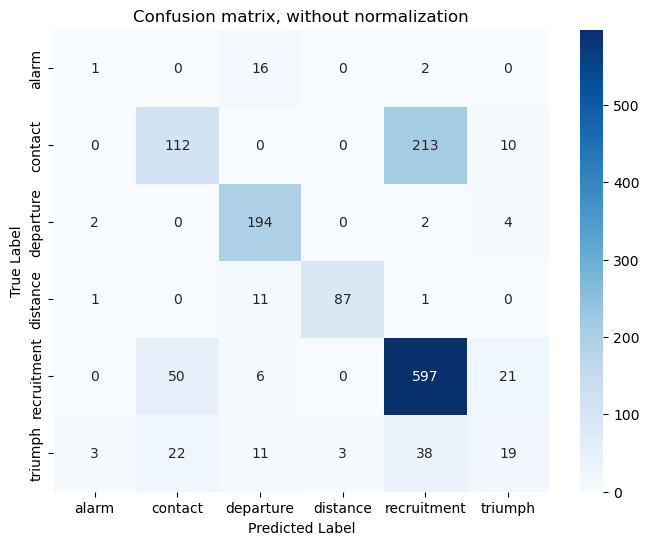

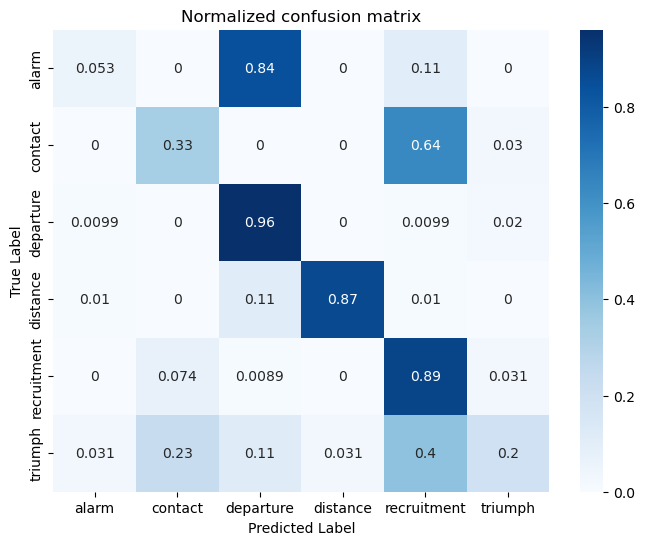

Feature coefficients per class:
    duration      t_q1   t_median       t_q3     std_t    skew_t    kurt_t  \
0  -2.878607  0.479847   0.863745  -3.451411  0.111643  0.526459 -0.671637   
1   0.094636  0.208993   1.189320  -0.623316 -0.067012  0.526568 -0.180604   
2  -3.409813 -1.327823   3.304346  -4.464971  0.814350 -0.346836 -0.005667   
3  14.166581  5.290582 -22.774499  19.733699  0.463487 -3.250987  2.665559   
4  -0.823199 -0.046673   1.233678  -1.305634 -0.283014  0.235646 -0.254053   
5  -1.599024 -2.362394   2.411058   1.889427  0.192653  0.406899 -0.163027   

   t_entropy    mean_f  mean_peak_f  ...  f_median      f_q3  mean_dom  \
0   9.452989  0.564873    -0.128990  ...  0.173488  0.065163 -0.061618   
1  -4.883545 -1.407742     0.146077  ...  0.196769  0.430421  0.115617   
2  10.127500  4.647909    -0.199855  ... -0.632150 -0.680434 -1.400503   
3   1.549758  2.725599    -0.634526  ... -0.541796 -0.068927  1.095752   
4  -1.369618 -0.911800     0.050121  ...  0.011732 

In [23]:
y_pred = lda.predict(X_test)
create_evaluation_plots(y_test, y_pred, le)
coef_df = pd.DataFrame(lda.coef_, columns=features_list, index=lda.classes_)
print("Feature coefficients per class:")
print(coef_df)

In [24]:
abs_coef = coef_df.abs().mean(axis=0)
print("Feature Importance Ranking:")
print(abs_coef.sort_values(ascending=False))

Feature Importance Ranking:
t_median                  5.296108
t_q3                      5.244743
t_entropy                 4.725621
duration                  3.828643
spectrographic_entropy    2.269342
mean_f                    1.860189
pse                       1.787791
t_q1                      1.619385
skew_t                    0.882232
kurt_t                    0.656758
mean_dom                  0.585750
f_q1                      0.461311
f_q3                      0.431873
min_dom                   0.383391
f_median                  0.372780
flatness_s                0.366353
std_t                     0.322026
max_dom                   0.315337
hnr                       0.298214
range_dom                 0.251199
mean_peak_f               0.243482
mod_dom                   0.151220
dtype: float64


Perform permutation test

https://scikit-learn.org/1.5/auto_examples/model_selection/plot_permutation_tests_for_classification.html#sphx-glr-auto-examples-model-selection-plot-permutation-tests-for-classification-py

In [25]:
cv = StratifiedGroupKFold(5, shuffle=True, random_state=RANDOM_SEED)
lda = LDA(solver="lsqr", shrinkage=0, n_components=1)

In [26]:
score, permutation_scores, pvalue = permutation_test_score(
    lda, X_scaled, y, random_state=RANDOM_SEED, cv=cv, n_permutations=500, groups=calls_df['track_ID']
)

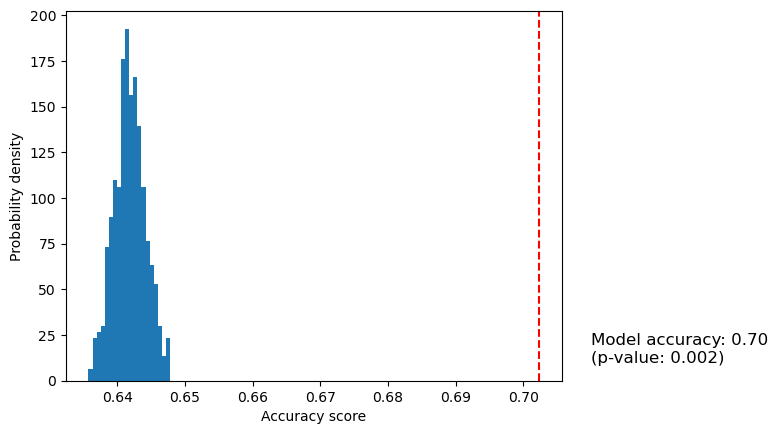

In [27]:
fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Model accuracy: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.71, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability density")
plt.show()

In [28]:
# simulate chance level
true_labels = calls_df["call_type"]
class_probs = true_labels.value_counts(normalize=True)
random_predictions = np.random.choice(class_probs.index, size=len(true_labels), p=class_probs.values)

# Calculate accuracy for random guessing
random_accuracy = accuracy_score(true_labels, random_predictions)

print("Chance Level (Random Guessing):", random_accuracy)


Chance Level (Random Guessing): 0.3027072520690139


#### VAE representations

In [29]:
X = np.array(calls_df["latent_representation"].tolist())
X_scaled = StandardScaler().fit_transform(X)
train_idxs, test_idxs, X_train, X_test, y_train, y_test = train_test_split(
    indices, X_scaled, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

In [30]:
X.shape

(7129, 128)

In [31]:
lda = LDA(solver="lsqr", shrinkage=0, n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1, shrinkage=0, solver='lsqr')

              precision    recall  f1-score   support

       alarm       0.00      0.00      0.00        13
     contact       0.57      0.40      0.47       339
   departure       0.83      0.91      0.87       199
    distance       0.91      0.85      0.88        87
 recruitment       0.71      0.86      0.78       700
     triumph       0.33      0.15      0.20        88

    accuracy                           0.70      1426
   macro avg       0.56      0.53      0.53      1426
weighted avg       0.68      0.70      0.68      1426



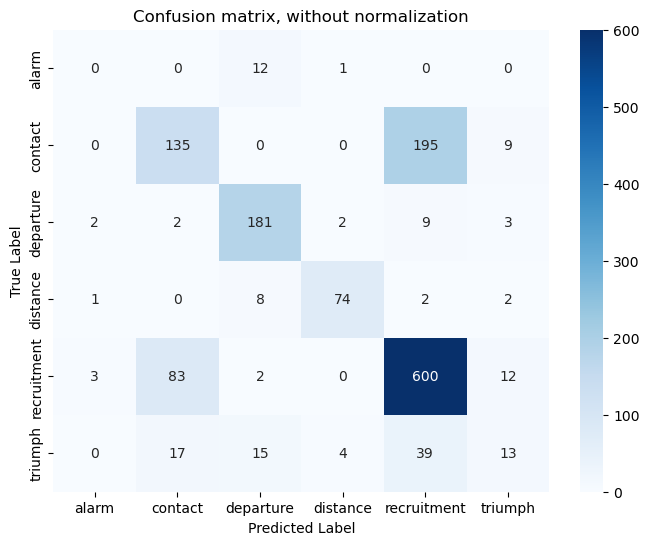

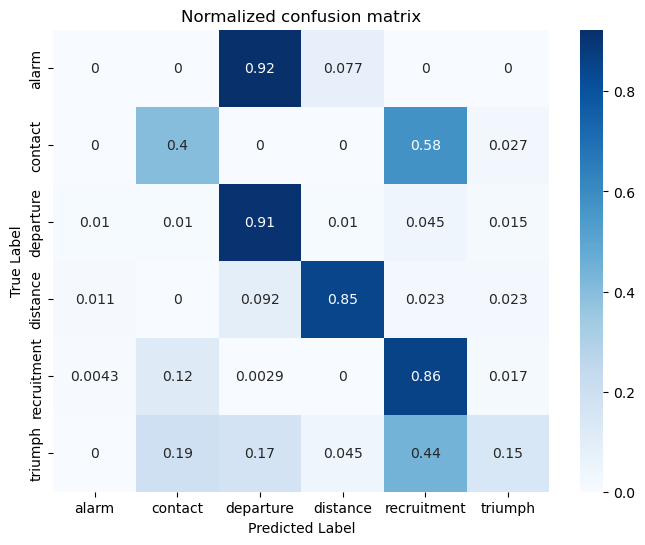

In [32]:
y_pred = lda.predict(X_test)
create_evaluation_plots(y_test, y_pred, le)

In [ ]:
cv = StratifiedGroupKFold(5, shuffle=True, random_state=RANDOM_SEED)
lda = LDA(solver="lsqr", shrinkage=0, n_components=1)

In [ ]:
score, permutation_scores, pvalue = permutation_test_score(
    lda, X_scaled, y, random_state=RANDOM_SEED, cv=cv, n_permutations=500, groups=calls_df['track_ID']
)

In [ ]:
fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Model accuracy: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.71, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability density")
plt.show()

## MLP

## CNN

In [33]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
N_EPOCHS = 5

In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [35]:
# data augmentation
image_transforms = Compose([
    Lambda(lambda img: torch.roll(img, shifts=random.randint(-40, 40), dims=-1)), # Random shift
    #Lambda(lambda spec: Normalize(spec)), 
])

#### LFCCs

In [36]:
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

In [37]:
lfccs_flat = np.array([x.flatten() for x in calls_df['log_padded_lfccs']]) 

scaler = StandardScaler()
lfccs_scaled = scaler.fit_transform(lfccs_flat)

# Reshape to original dimensions
n_samples, height, width = len(calls_df), calls_df['log_padded_lfccs'][0].shape[0], calls_df['log_padded_lfccs'][0].shape[1]
lfccs_scaled = lfccs_scaled.reshape(n_samples, height, width)  

# Assign the scaled features back to the DataFrame if needed
calls_df['log_padded_lfccs_scaled'] = list(lfccs_scaled)

In [38]:
class LFCCDataset(Dataset):
    def __init__(self, df, transform=True):
        self.df = df
        self.groups = df["track_ID"]
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.df.iloc[idx]["log_padded_lfccs_scaled"]).to(torch.float32).to(device)
        x = x[np.newaxis, ...] # Add channel dimension -> Shape: (1, 16, 215)
        if self.transform:
            x = image_transforms(x)
        return x, self.df.iloc[idx]["encoded_call_type"]

ds_lfcc = LFCCDataset(calls_df)

num_items = len(ds_lfcc)
num_train = round(num_items * 0.8)
num_val = round(num_items * 0.1)
num_test = num_items - num_train - num_val
train_ds, val_ds, test_ds = random_split(ds_lfcc, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 16, 215])
16 215


In [40]:
class LFCCCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.layers = torch.nn.Sequential( # (1, 16, 215)
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1), # (32, 16, 215)
            nn.MaxPool2d(kernel_size=(2, 2)), # (32, 8, 107)
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1), # (64, 8, 107)
            nn.Flatten(),
            nn.Linear(64 * 8 * 107, 128),  # flattened size: 64 * (16/2) * (215/2)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [41]:
# Instantiate model
n_classes = 6
model = LFCCCNN(n_classes)

# Loss and Optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.to(device)

# Train
n_epochs = N_EPOCHS
train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)

# Evaluate
val_targets, val_predictions, _ = test_model(model, val_dl, device)
print(f"Validation Accuracy: {accuracy_score(val_targets, val_predictions):.4f}")

Epoch 1/5, Loss: 1.7186
Epoch 2/5, Loss: 0.7887
Epoch 3/5, Loss: 0.7122
Epoch 4/5, Loss: 0.6337
Epoch 5/5, Loss: 0.6477
Validation Accuracy: 0.7321


              precision    recall  f1-score   support

       alarm       0.17      0.07      0.10        15
     contact       0.64      0.35      0.45       166
   departure       0.86      0.91      0.88        97
    distance       0.92      0.92      0.92        61
 recruitment       0.73      0.95      0.83       335
     triumph       0.70      0.36      0.47        39

    accuracy                           0.75       713
   macro avg       0.67      0.59      0.61       713
weighted avg       0.73      0.75      0.72       713



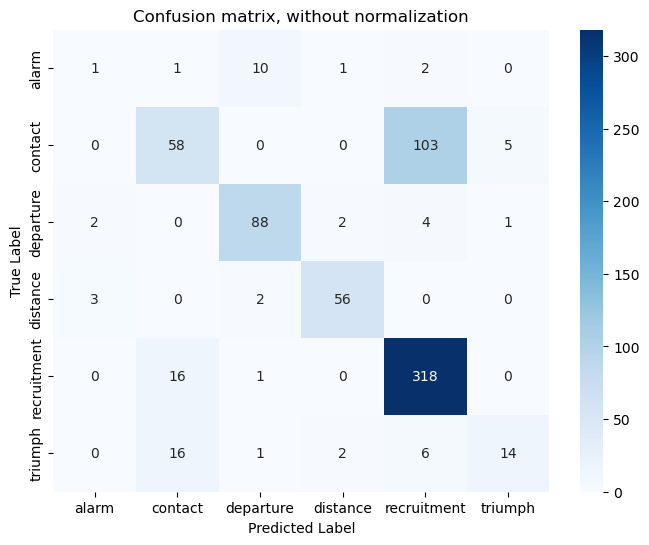

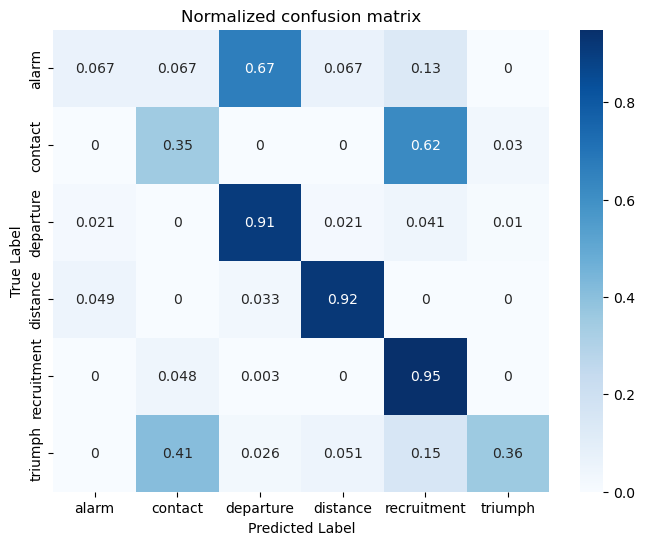

In [42]:
evaluate_model(model, test_dl, device, le, num_classes=6)

#### Spectrograms

In [43]:
specs_flat = np.array([x.flatten() for x in calls_df['log_padded_spectrogram']]) 

scaler = StandardScaler()
specs_scaled = scaler.fit_transform(specs_flat)

# Reshape to original dimensions
n_samples, height, width = len(calls_df), calls_df['log_padded_spectrogram'][0].shape[0], calls_df['log_padded_spectrogram'][0].shape[1]
specs_scaled = specs_scaled.reshape(n_samples, height, width)  

# Assign the scaled features back to the DataFrame if needed
calls_df['log_padded_spectrogram_scaled'] = list(specs_scaled)

In [44]:
class SpecDataset(Dataset):
    def __init__(self, df, transform=True):
        self.df = df
        self.groups = df["track_ID"]
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.df.iloc[idx]["log_padded_spectrogram_scaled"]).to(torch.float32).to(device) # Shape: (n_samples, 16, 215)
        x = x[np.newaxis, ...] # Add channel dimension -> Shape: (1, 16, 215)
        if self.transform:
            x = image_transforms(x)
        return x, self.df.iloc[idx]["encoded_call_type"]

ds_spec = SpecDataset(calls_df)

num_items = len(ds_spec)
num_train = round(num_items * 0.7)
num_val = round(num_items * 0.15)
num_test = num_items - num_train - num_val
train_ds, val_ds, test_ds = random_split(ds_spec, [num_train, num_val, num_test])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [45]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 44, 170])
44 170


In [46]:
class SpecCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.layers = torch.nn.Sequential( # (1, 44, 170)
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1), # (16, 44, 170)
            nn.MaxPool2d(kernel_size=(2, 2)), # (16, 22, 85)
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), # (32, 22, 85)
            nn.Flatten(),
            nn.Linear(32 * 22 * 85, 128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [47]:
# Instantiate model
n_classes = 6
model = SpecCNN(n_classes)

# Loss and Optimizer
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.to(device)

# Train
n_epochs = N_EPOCHS
train_model(model, n_epochs, train_dl, device, optimizer, loss_criterion)

# Evaluate
val_targets, val_predictions, _ = test_model(model, val_dl, device)
print(f"Validation Accuracy: {accuracy_score(val_targets, val_predictions):.4f}")

Epoch 1/5, Loss: 3.6739
Epoch 2/5, Loss: 1.0934
Epoch 3/5, Loss: 0.7226
Epoch 4/5, Loss: 0.6197
Epoch 5/5, Loss: 0.6095
Validation Accuracy: 0.7456


              precision    recall  f1-score   support

       alarm       0.00      0.00      0.00         9
     contact       0.61      0.49      0.54       237
   departure       0.92      0.85      0.88       156
    distance       0.82      0.90      0.86        61
 recruitment       0.78      0.90      0.84       526
     triumph       0.65      0.41      0.50        81

    accuracy                           0.76      1070
   macro avg       0.63      0.59      0.60      1070
weighted avg       0.75      0.76      0.75      1070



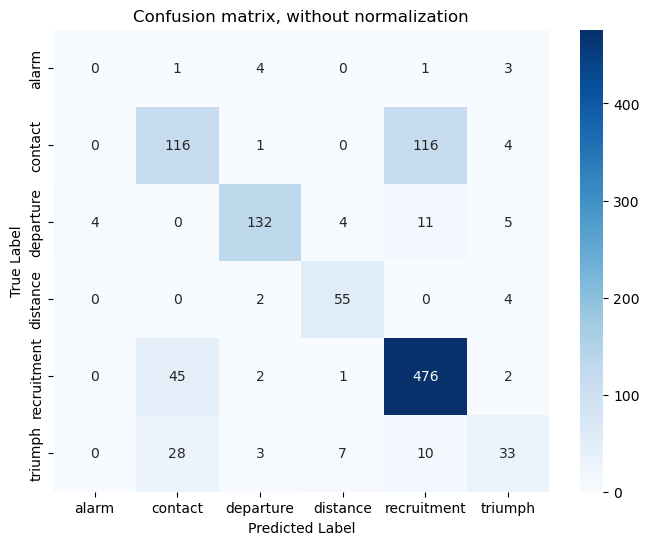

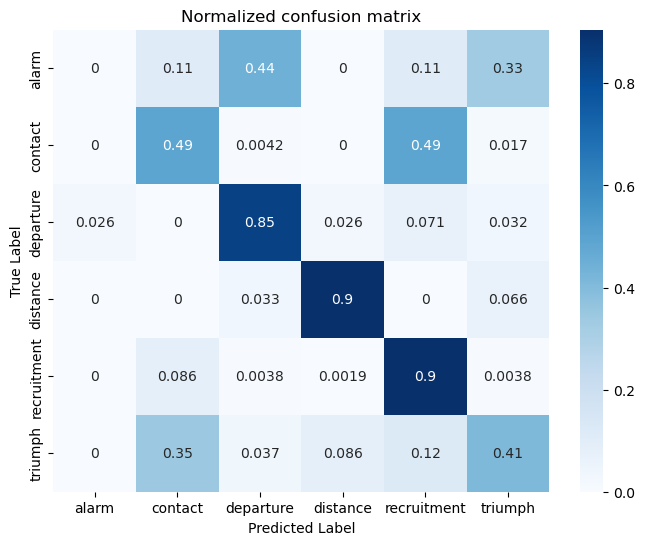

In [48]:
evaluate_model(model, test_dl, device, le, num_classes=6)


--- Fold 1 ---
Epoch 1/35, Loss: 2.1090
Epoch 2/35, Loss: 0.7879
Epoch 3/35, Loss: 0.6800
Epoch 4/35, Loss: 0.5921
Epoch 5/35, Loss: 0.5781
Epoch 6/35, Loss: 0.5705
Epoch 7/35, Loss: 0.5775
Epoch 8/35, Loss: 0.5625
Epoch 9/35, Loss: 0.5521
Epoch 10/35, Loss: 0.5381
Epoch 11/35, Loss: 0.5374
Epoch 12/35, Loss: 0.5388
Epoch 13/35, Loss: 0.5222
Epoch 14/35, Loss: 0.5234
Epoch 15/35, Loss: 0.5193
Epoch 16/35, Loss: 0.5208
Epoch 17/35, Loss: 0.5216
Epoch 18/35, Loss: 0.5037
Epoch 19/35, Loss: 0.5047
Epoch 20/35, Loss: 0.4974
Epoch 21/35, Loss: 0.4897
Epoch 22/35, Loss: 0.4784
Epoch 23/35, Loss: 0.4760
Epoch 24/35, Loss: 0.4783
Epoch 25/35, Loss: 0.4874
Epoch 26/35, Loss: 0.4877
Epoch 27/35, Loss: 0.4636
Epoch 28/35, Loss: 0.4694
Epoch 29/35, Loss: 0.4707
Epoch 30/35, Loss: 0.4738
Epoch 31/35, Loss: 0.4622
Epoch 32/35, Loss: 0.4626
Epoch 33/35, Loss: 0.4579
Epoch 34/35, Loss: 0.4606
Epoch 35/35, Loss: 0.4565

Validation Accuracy for Fold 1: 0.6971
  Micro-averaged One-vs-Rest ROC AUC score:

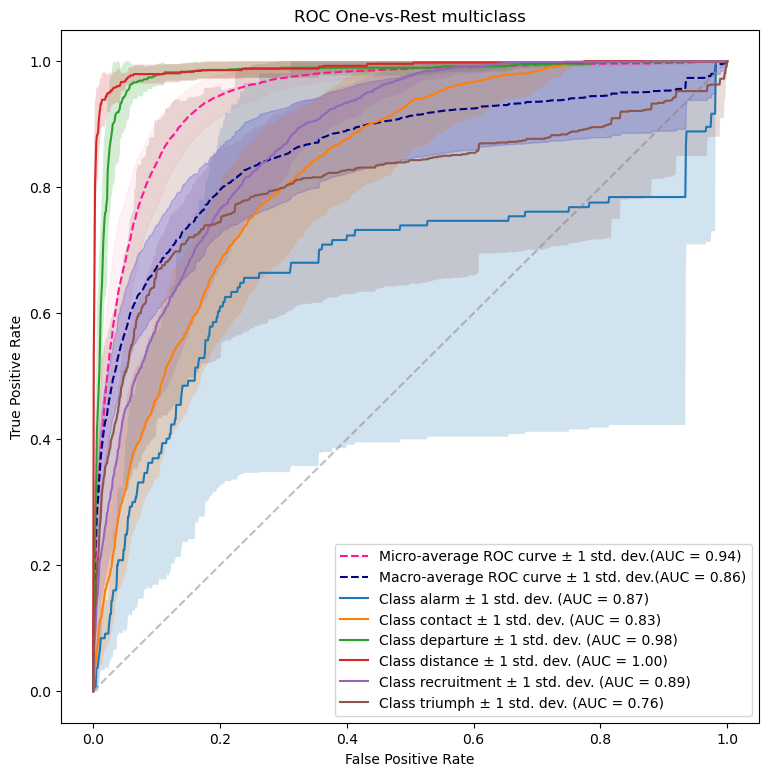

In [49]:
summary = cross_validate(ds_spec, SpecCNN, device, le, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_splits=6, n_epochs=35, n_classes=6)


--- Fold 1 ---
Epoch 1/25, Loss: 2.6580
Epoch 2/25, Loss: 0.8766
Epoch 3/25, Loss: 0.6658
Epoch 4/25, Loss: 0.6241
Epoch 5/25, Loss: 0.6163
Epoch 6/25, Loss: 0.6047
Epoch 7/25, Loss: 0.6005
Epoch 8/25, Loss: 0.6040
Epoch 9/25, Loss: 0.5732
Epoch 10/25, Loss: 0.5752
Epoch 11/25, Loss: 0.5731
Epoch 12/25, Loss: 0.5819
Epoch 13/25, Loss: 0.5749
Epoch 14/25, Loss: 0.5701
Epoch 15/25, Loss: 0.5712
Epoch 16/25, Loss: 0.5649
Epoch 17/25, Loss: 0.5531
Epoch 18/25, Loss: 0.5518
Epoch 19/25, Loss: 0.5733
Epoch 20/25, Loss: 0.5578
Epoch 21/25, Loss: 0.5398
Epoch 22/25, Loss: 0.5451
Epoch 23/25, Loss: 0.5327
Epoch 24/25, Loss: 0.5531
Epoch 25/25, Loss: 0.5402

Validation Accuracy for Fold 1: 0.7203
  Micro-averaged One-vs-Rest ROC AUC score: 0.94
  Macro-averaged One-vs-Rest ROC AUC score: 0.77
  Accuracy: 0.7203
  Precision (weighted): 0.7070
  Recall (weighted): 0.7203
  F1-score (weighted): 0.7021

--- Fold 2 ---
Epoch 1/25, Loss: 1.9473
Epoch 2/25, Loss: 0.8072
Epoch 3/25, Loss: 0.6690
Epoch 

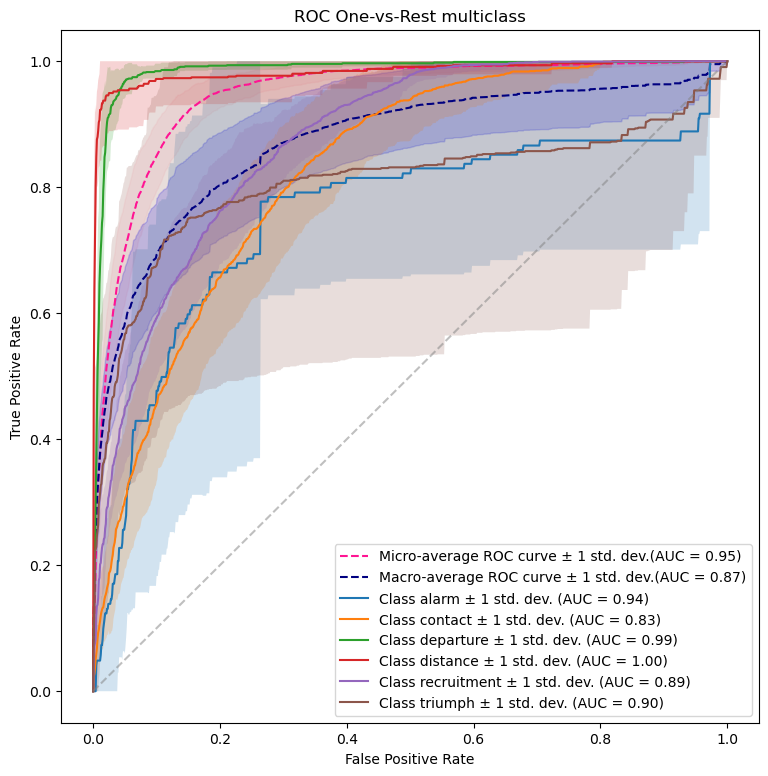

In [50]:
summary = cross_validate(ds_lfcc, LFCCCNN, device, le, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, n_splits=6, n_epochs=25, n_classes=6)